In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [25]:
df_seq = pd.read_csv("seq_results.tsv", sep="\t")
df_par = pd.read_csv("par_results.tsv", sep="\t")
df_seq["type"] = "sequential"
df_par["type"] = "parallel"

df = pd.concat([df_seq, df_par])

def convert_time(exec_time):
    minutes = float(exec_time.split("m")[0])
    seconds = float(exec_time.split("m")[1].split("s")[0])
    return minutes * 60 + seconds

def scheduling_type(scheduling):
    if str(scheduling) == 'nan':
        return None
    return scheduling.split(",")[0]

def chunk_size(scheduling):
    if str(scheduling) == 'nan':
        return None
    try: 
        return int(scheduling.split(",")[1])
    except IndexError:
        return None

df["time"] = df["time"].apply(convert_time)

df["scheduling_type"] = df["scheduling"].apply(scheduling_type)
df["scheduling_chunk_size"] = df["scheduling"].apply(chunk_size)

def calculate_absolute_speedup(df):
    sequential_time = df[df["type"]=="sequential"]["time"].mean()
    df["absolute_speedup"] = np.nan
    df.loc[df["type"] == "parallel", 'absolute_speedup'] = sequential_time / df[df["type"] == "parallel"]["time"]
    return df

df = df.groupby(['tab_size'], as_index=False).apply(calculate_absolute_speedup)

df = df.groupby(['type', 'tab_size', 'scheduling_type', 'scheduling_chunk_size'], as_index=False).agg({'time':['mean','std'], 'absolute_speedup':['mean','std']})

# tmp = df.groupby(['type', 'problem_size', 'instance_type'], as_index=False)

df


type   tab_size scheduling_type scheduling_chunk_size    time  \
                                                                 mean   
0   parallel          2         dynamic                   1.0  0.0031   
1   parallel          2         dynamic                   4.0  0.0042   
2   parallel          2         dynamic                  64.0  0.0024   
3   parallel          2         dynamic                4096.0  0.0021   
4   parallel          2          static                   1.0  0.0022   
..       ...        ...             ...                   ...     ...   
67  parallel  200000000         dynamic                4096.0  0.9122   
68  parallel  200000000          static                   1.0  1.9661   
69  parallel  200000000          static                   4.0  1.1387   
70  parallel  200000000          static                  64.0  0.9433   
71  parallel  200000000          static                4096.0  0.9189   

             absolute_speedup            
         std             mean       std  
0   0.002234         0.945556  0.340474  
1   0.003048         0.776889  0.377554  
2   0.000699         1.015833  0.222238  
3   0.000316         1.111667  0.121221  
4   0.000422         1.073333  0.161628  
..       ...              ...       ...  
67  0.002348         4.945436  0.012749  
68  0.013812         2.294593  0.016054  
69  0.012928         3.962164  0.044406  
70  0.013064         4.783168  0.064875  
71  0.002923         4.909393  0.015722  

[72 rows x 8 columns]

In [53]:
def add_to_plot(x, y, df, color, label, div = None):
    if div is None:
        df = df.sort_values(by=[x])
        plt.loglog(df[x], df[y]["mean"], 'o--', color=color, label=label)
        plt.errorbar(df[x], df[y]["mean"], df[y]["std"], linestyle='None', color=color, zorder=3, elinewidth=1, capsize=2)
    else:
        df = df.sort_values(by=[x])
        plt.loglog(df[x], df[y]["mean"] / df[y].iloc[0]["mean"], 'o--', color=color, label=label)
#         plt.errorbar(df[x], df[y]["mean"], df[y]["std"] / df[y].iloc[0]["std"], linestyle='None', color=color, zorder=3, elinewidth=1, capsize=2)

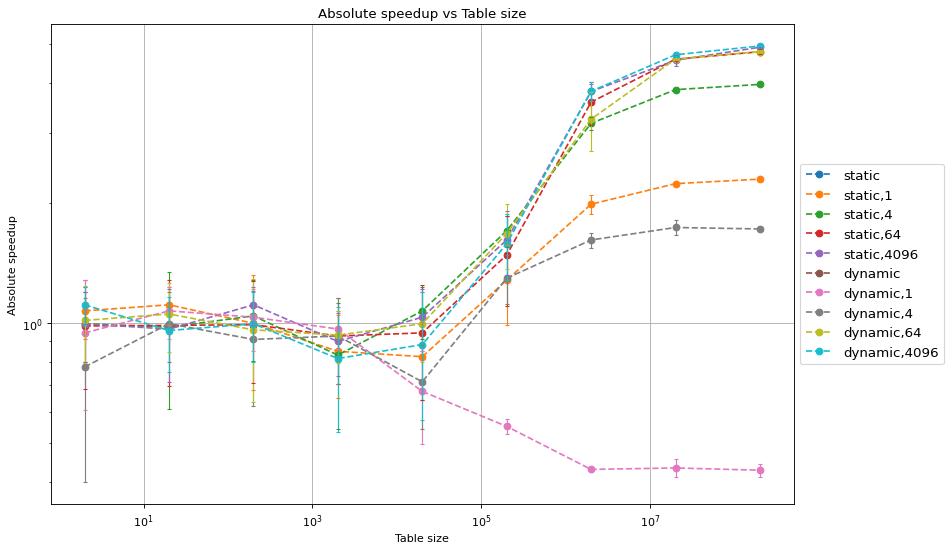

In [54]:
import matplotlib.colors as mcolors
colors = list(mcolors.TABLEAU_COLORS)

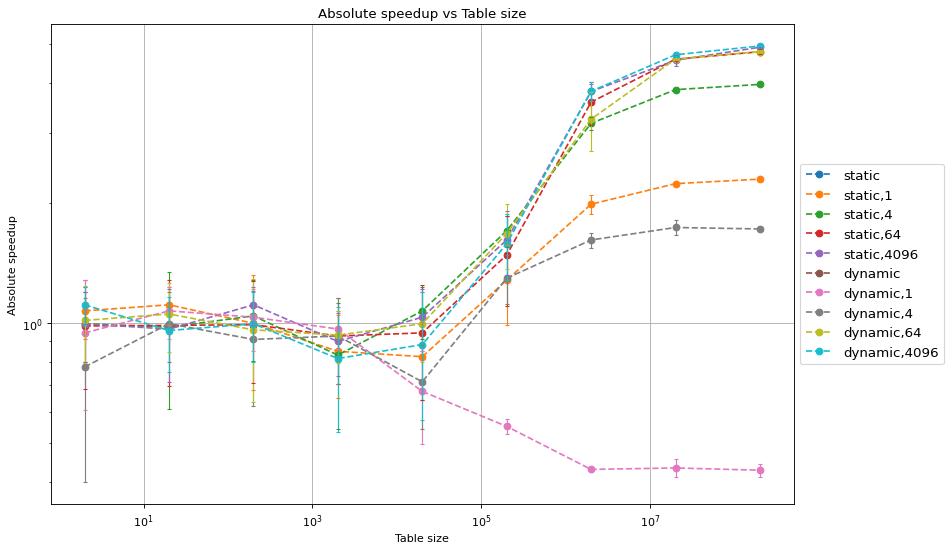

In [55]:
plt.figure(figsize=(12, 7), dpi=80)
plt.title("Absolute speedup vs Table size")
plt.xlabel("Table size")
plt.ylabel("Absolute speedup")

add_to_plot('tab_size', 'absolute_speedup', df[(df['type'] == 'parallel') & (df['scheduling_type'] == 'static') & (df['scheduling_chunk_size'] == None)], colors[0], "static")
add_to_plot('tab_size', 'absolute_speedup', df[(df['type'] == 'parallel') & (df['scheduling_type'] == 'static') & (df['scheduling_chunk_size'] == 1)], colors[1], "static,1")
add_to_plot('tab_size', 'absolute_speedup', df[(df['type'] == 'parallel') & (df['scheduling_type'] == 'static') & (df['scheduling_chunk_size'] == 4)], colors[2], "static,4")
add_to_plot('tab_size', 'absolute_speedup', df[(df['type'] == 'parallel') & (df['scheduling_type'] == 'static') & (df['scheduling_chunk_size'] == 64)], colors[3], "static,64")
add_to_plot('tab_size', 'absolute_speedup', df[(df['type'] == 'parallel') & (df['scheduling_type'] == 'static') & (df['scheduling_chunk_size'] == 4096)], colors[4], "static,4096")

add_to_plot('tab_size', 'absolute_speedup', df[(df['type'] == 'parallel') & (df['scheduling_type'] == 'dynamic') & (df['scheduling_chunk_size'] == None)], colors[5], "dynamic")
add_to_plot('tab_size', 'absolute_speedup', df[(df['type'] == 'parallel') & (df['scheduling_type'] == 'dynamic') & (df['scheduling_chunk_size'] == 1)], colors[6], "dynamic,1")
add_to_plot('tab_size', 'absolute_speedup', df[(df['type'] == 'parallel') & (df['scheduling_type'] == 'dynamic') & (df['scheduling_chunk_size'] == 4)], colors[7], "dynamic,4")
add_to_plot('tab_size', 'absolute_speedup', df[(df['type'] == 'parallel') & (df['scheduling_type'] == 'dynamic') & (df['scheduling_chunk_size'] == 64)], colors[8], "dynamic,64")
add_to_plot('tab_size', 'absolute_speedup', df[(df['type'] == 'parallel') & (df['scheduling_type'] == 'dynamic') & (df['scheduling_chunk_size'] == 4096)], colors[9], "dynamic,4096")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 12})
plt.tight_layout()
plt.grid()
plt.show()

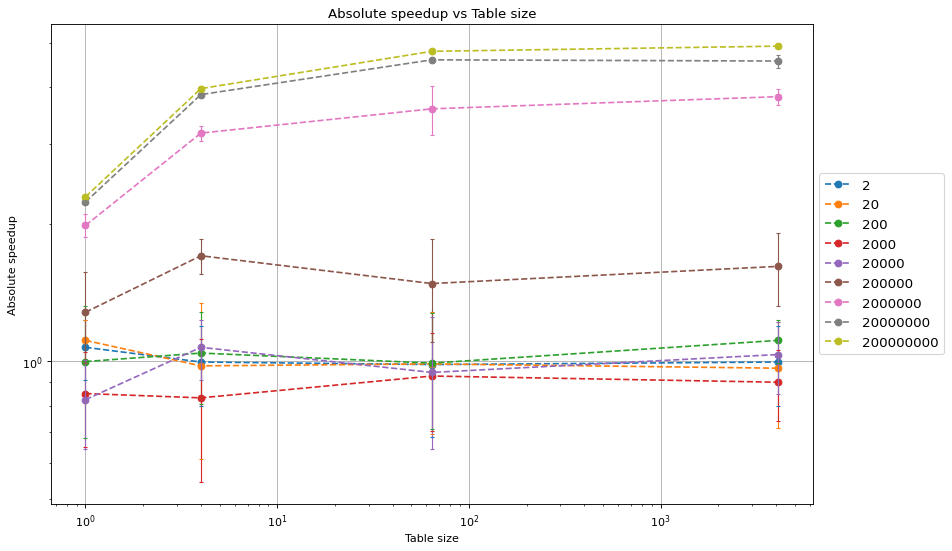

In [56]:
plt.figure(figsize=(12, 7), dpi=80)
plt.title("Absolute speedup vs chunk size" )
plt.xlabel("Table size")
plt.ylabel("Absolute speedup")

add_to_plot('scheduling_chunk_size', 'absolute_speedup', df[(df['type'] == 'parallel') & (df['scheduling_type'] == 'static') & (df['tab_size'] == 2)], colors[0], "2")
add_to_plot('scheduling_chunk_size', 'absolute_speedup', df[(df['type'] == 'parallel') & (df['scheduling_type'] == 'static') & (df['tab_size'] == 20)], colors[1], "20")
add_to_plot('scheduling_chunk_size', 'absolute_speedup', df[(df['type'] == 'parallel') & (df['scheduling_type'] == 'static') & (df['tab_size'] == 200)], colors[2], "200")
add_to_plot('scheduling_chunk_size', 'absolute_speedup', df[(df['type'] == 'parallel') & (df['scheduling_type'] == 'static') & (df['tab_size'] == 2000)], colors[3], "2000")
add_to_plot('scheduling_chunk_size', 'absolute_speedup', df[(df['type'] == 'parallel') & (df['scheduling_type'] == 'static') & (df['tab_size'] == 20000)], colors[4], "20000")
add_to_plot('scheduling_chunk_size', 'absolute_speedup', df[(df['type'] == 'parallel') & (df['scheduling_type'] == 'static') & (df['tab_size'] == 200000)], colors[5], "200000")
add_to_plot('scheduling_chunk_size', 'absolute_speedup', df[(df['type'] == 'parallel') & (df['scheduling_type'] == 'static') & (df['tab_size'] == 2000000)], colors[6], "2000000")
add_to_plot('scheduling_chunk_size', 'absolute_speedup', df[(df['type'] == 'parallel') & (df['scheduling_type'] == 'static') & (df['tab_size'] == 20000000)], colors[7], "20000000")
add_to_plot('scheduling_chunk_size', 'absolute_speedup', df[(df['type'] == 'parallel') & (df['scheduling_type'] == 'static') & (df['tab_size'] == 200000000)], colors[8], "200000000")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 12})
plt.tight_layout()
plt.grid()
plt.show()